In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import time


import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications import VGG16
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from sklearn.datasets import load_files
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
data_dir =  r'/gdrive/My Drive/X-Ray_Image_DataSet'

#Load Data
data = load_files(data_dir)

In [ ]:
folders=os.listdir("/gdrive/My Drive/X-Ray_Image_DataSet")
print(folders)

['PositiveCovid-19', 'NegativeCovid-19']


In [ ]:
#Convert the data and labels to Numpy arrays
X = np.array(data['filenames'])
y = np.array(data['target'])
labels = np.array(data['target_names'])

print('Data files - ',X[0])
print('Target labels - ',y[0])
print('Number of training files : ', X.shape[0])
print('Number of training targets : ', y.shape[0])

Data files -  /gdrive/My Drive/X-Ray_Image_DataSet/NegativeCovid-19/00002678_004.png
Target labels -  0
Number of training files :  868
Number of training targets :  868


In [ ]:
def convert_img_to_arr(file_path_list):
    arr = []
    img_width, img_height = 224,224
    #Loop over the image paths
    for file_path in file_path_list:
        """
           Load the image, swap color channels, and resize it to be a fixed
           224*224 pixels while ignoring aspect ratio
        """
        img = load_img(file_path, target_size = (img_width, img_height))
        img = img_to_array(img)

        #update the data
        arr.append(img)
    return arr

X = np.array(convert_img_to_arr(X))

# The Data Shape
print(X.shape)
print('First training item : ',X[0])

(868, 224, 224, 3)
First training item :  [[[ 42.  42.  42.]
  [ 41.  41.  41.]
  [ 39.  39.  39.]
  ...
  [143. 143. 143.]
  [145. 145. 145.]
  [155. 155. 155.]]

 [[ 35.  35.  35.]
  [ 34.  34.  34.]
  [ 33.  33.  33.]
  ...
  [143. 143. 143.]
  [146. 146. 146.]
  [155. 155. 155.]]

 [[ 29.  29.  29.]
  [ 28.  28.  28.]
  [ 27.  27.  27.]
  ...
  [146. 146. 146.]
  [150. 150. 150.]
  [161. 161. 161.]]

 ...

 [[ 28.  28.  28.]
  [ 27.  27.  27.]
  [ 28.  28.  28.]
  ...
  [ 67.  67.  67.]
  [ 89.  89.  89.]
  [118. 118. 118.]]

 [[ 28.  28.  28.]
  [ 28.  28.  28.]
  [ 28.  28.  28.]
  ...
  [ 67.  67.  67.]
  [ 89.  89.  89.]
  [118. 118. 118.]]

 [[ 29.  29.  29.]
  [ 29.  29.  29.]
  [ 29.  29.  29.]
  ...
  [ 68.  68.  68.]
  [ 91.  91.  91.]
  [120. 120. 120.]]]


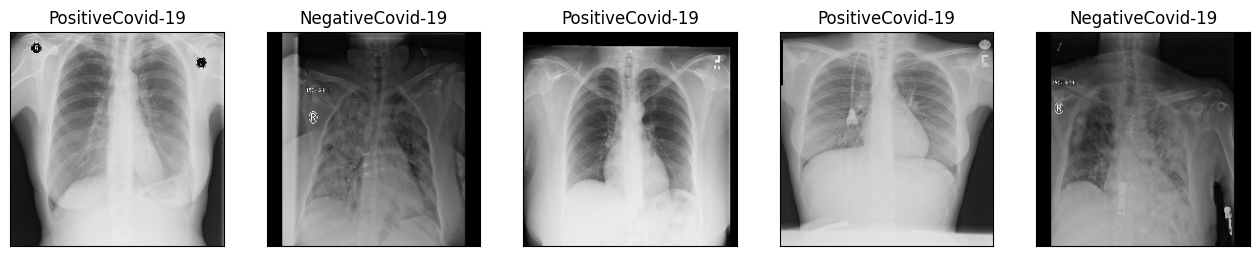

In [ ]:
#First 5 training data.
fig = plt.figure(figsize = (16,9))
for i in range(5):
    ax = fig.add_subplot(1,5,i+1,xticks=[],yticks=[])
    ax.imshow((X[i].astype(np.uint8)))
    plt.title(folders[y[i]])

In [ ]:
# Scale the pixel intenties to the range[0,255]
X = X.astype('float32')/255

# Confirm the number of classes
no_of_classes = len(np.unique(y))
no_of_classes

2

In [ ]:
y = np.array(to_categorical(y,no_of_classes))
y[0]

array([1., 0.], dtype=float32)

In [ ]:
# Splitting dataset (train to 80%) (valdiation to 10%) (test to 10%)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
print('The train Data Shape ', X_train.shape[0])

X_test, X_valid, y_test, y_valid = train_test_split(X_test,y_test, test_size = 0.5)
print('The validation Data Shape ', X_valid.shape[0])
print('The test Data Shape ', X_test.shape[0])

The train Data Shape  694
The validation Data Shape  87
The test Data Shape  87


In [ ]:
print('The train Data Shape ', X_train.shape[1:])

The train Data Shape  (224, 224, 3)


#CNN ResNet50 PreTrained Model

In [ ]:
from keras.applications import ResNet50
from keras.layers import BatchNormalization

In [ ]:
model = Sequential()

model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(no_of_classes, activation='softmax'))

model.layers[0].trainable = False

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 1024)              2

In [ ]:
lr = 1e-3
epochs = 50
bs = 8
optimizer = Adam(learning_rate = lr)
model.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Model Training
epochs = 30

#initialize the training data augmentation object
train_datagen = ImageDataGenerator(
        rotation_range=15,
        fill_mode ="nearest")

checkpointer = ModelCheckpoint(filepath = "/gdrive/My Drive/Kel2RestNet50.h5", save_best_only = True, verbose=1)
start = time.time()

history=model.fit_generator(train_datagen.flow(X_train, y_train, batch_size = bs),
                            steps_per_epoch = len(X_train)//bs,
                            validation_data = (X_valid, y_valid),
                            validation_steps = len(X_valid)//bs,
                            epochs =epochs,
                            callbacks= [checkpointer])

end = time.time()
duration = end - start
print ('\n This Model took %0.5f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs) )

<ipython-input-17-9d60743821c9>:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_datagen.flow(X_train, y_train, batch_size = bs),


Epoch 1/30
86/86 [==============================] - ETA: 0s - loss: 0.7324 - accuracy: 0.7653
Epoch 1: val_loss improved from inf to 0.88348, saving model to /gdrive/My Drive/Kel2RestNet50.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


86/86 [==============================] - 27s 162ms/step - loss: 0.7324 - accuracy: 0.7653 - val_loss: 0.8835 - val_accuracy: 0.6207
Epoch 2/30
86/86 [==============================] - ETA: 0s - loss: 0.3472 - accuracy: 0.8659
Epoch 2: val_loss improved from 0.88348 to 0.61574, saving model to /gdrive/My Drive/Kel2RestNet50.h5
86/86 [==============================] - 12s 135ms/step - loss: 0.3472 - accuracy: 0.8659 - val_loss: 0.6157 - val_accuracy: 0.6322
Epoch 3/30
86/86 [==============================] - ETA: 0s - loss: 0.3196 - accuracy: 0.8673
Epoch 3: val_loss improved from 0.61574 to 0.54872, saving model to /gdrive/My Drive/Kel2RestNet50.h5
86/86 [==============================] - 11s 130ms/step - loss: 0.3196 - accuracy: 0.8673 - val_loss: 0.5487 - val_accuracy: 0.6437
Epoch 4/30
86/86 [==============================] - ETA: 0s - loss: 0.2942 - accuracy: 0.8776
Epoch 4: val_loss did not improve from 0.54872
86/86 [==============================] - 9s 106ms/step - loss: 0.2942 -

In [ ]:
(eval_loss, eval_accuracy) = model.evaluate(
     X_test, y_test, batch_size=bs, verbose=2)

print("Accuracy: {:.5f}%".format(eval_accuracy * 100))
print("Loss: {}".format(eval_loss))

11/11 - 1s - loss: 0.2963 - accuracy: 0.9080 - 1s/epoch - 136ms/step
Accuracy: 90.80459%
Loss: 0.29634031653404236


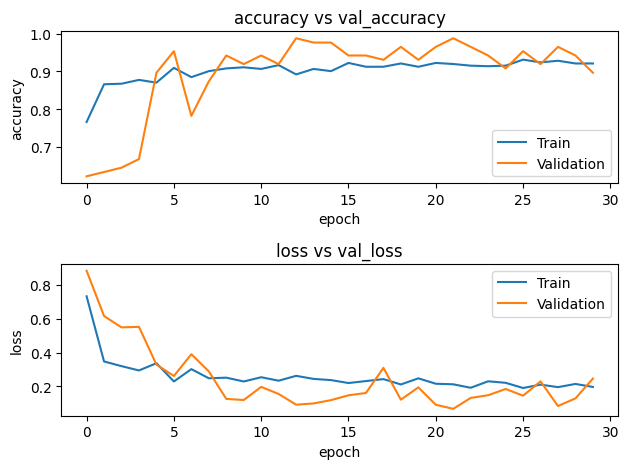

In [ ]:
# Visualizing the train/validation

import matplotlib.pyplot as plt
def plot(history):
    plt.figure(1)

    # Accuracy
    plt.subplot(211)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('accuracy vs val_accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Loss
    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss vs val_loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.show()

plot(history)

3/3 [==============================] - 0s 115ms/step


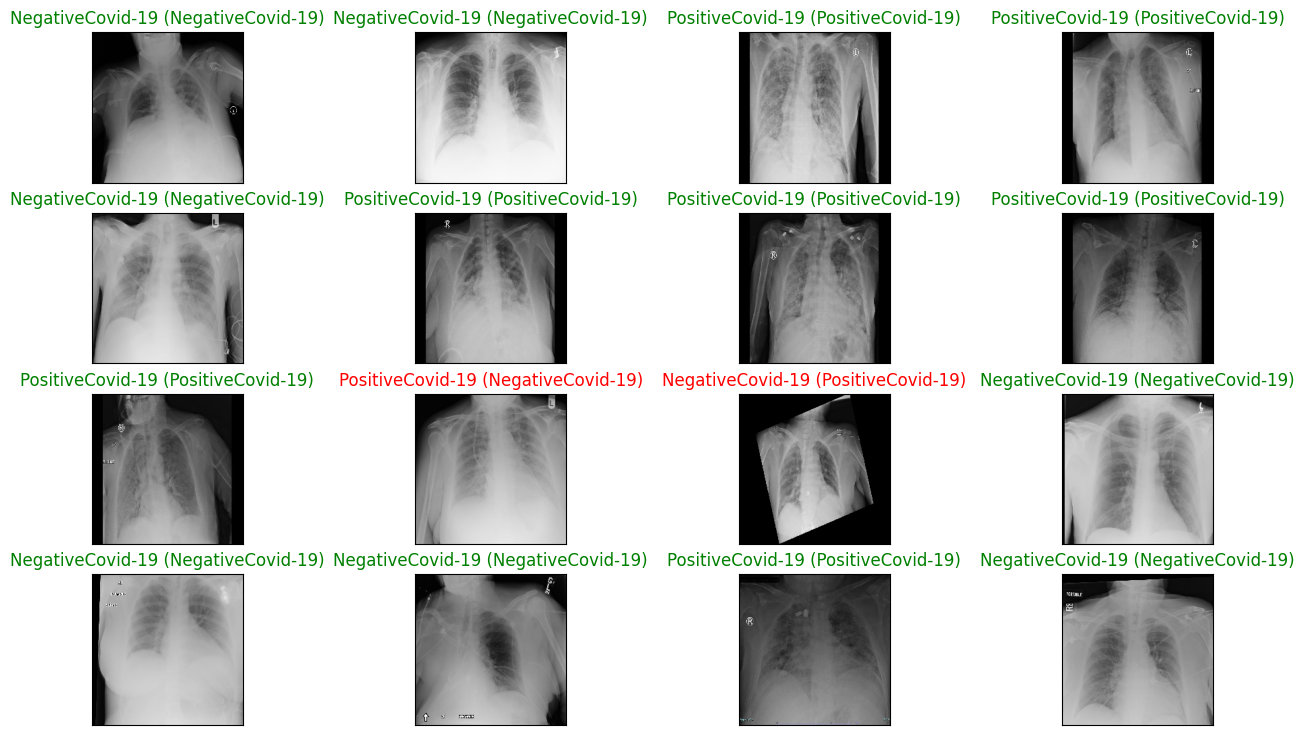

In [ ]:
# Visualize some random test prediction.
def visualize_pred(y_pred):
# plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(16, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize_pred(model.predict(X_test))

3/3 [==============================] - 0s 121ms/step


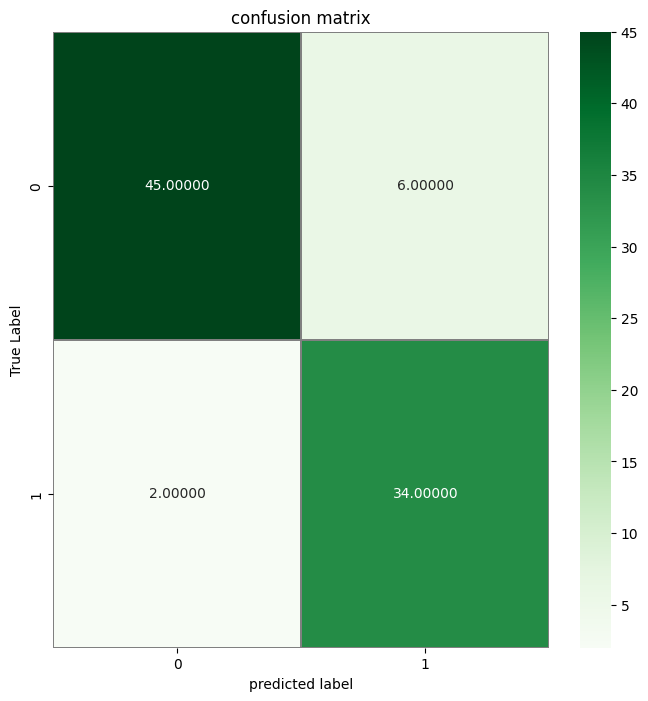

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)
confusion_mtx = confusion_matrix(Y_true,Y_pred_classes)
f,ax = plt.subplots(figsize = (8,8))
sns.heatmap(confusion_mtx,annot=True,linewidths = 0.01,cmap="Greens",
            linecolor = "gray",fmt = ".5f",ax=ax
            )
plt.xlabel("predicted label")
plt.ylabel("True Label")
plt.title("confusion matrix")
plt.show()

In [ ]:
print(classification_report(y_test.argmax(axis=1),Y_pred_classes, target_names= labels, digits = 5))

                  precision    recall  f1-score   support

NegativeCovid-19    0.95745   0.88235   0.91837        51
PositiveCovid-19    0.85000   0.94444   0.89474        36

        accuracy                        0.90805        87
       macro avg    0.90372   0.91340   0.90655        87
    weighted avg    0.91299   0.90805   0.90859        87

